In [9]:
import sys, os
import torch
import pandas as pd
import glob
from tqdm import tqdm
from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

local_user_path = '/home/jgershon/git/cleo' # change to your own path
sys.path.append(local_user_path) 
from ensemble import Ensemble
from data_util import FragmentDataset

### load model and check prediction accuracy

In [2]:
ls /home/jgershon/git/cleo/data

four-site_clean_simplified_AA_data.csv
four-site_clean_simplified_AA_data_2k_train_random_test.csv
four-site_fragments.csv
four-site_simplified_AA_data.csv


In [3]:
# path to model checkpoint


# base_path = '/home/jgershon/git/cleo/ckpt/nll_10models_softplus_batch4_split/nll_10models_softplus_batch4_split:2024-10-26-16-16-13'
# base_path = '/home/jgershon/git/cleo/ckpt/nll_10models_softplus_batch2_split/nll_10models_softplus_batch2_split:2024-10-26-16-36-42'
# base_path = '/home/jgershon/git/cleo/ckpt/nll_10models_softplus_batch1_split/nll_10models_softplus_batch1_split:2024-10-26-16-52-51'
# base_path = '/home/jgershon/git/cleo/ckpt/nll_10models_softplus_batch1_split_hidden16/nll_10models_softplus_batch1_split_hidden16:2024-10-26-19-53-56'
base_path = '/home/jgershon/git/cleo/ckpt/nll_10models_softplus_batch1_split_hidden8/nll_10models_softplus_batch1_split_hidden8:2024-10-27-01-23-40'
# base_path = '/home/jgershon/git/cleo/ckpt/nll_10models_softplus_batch1_split_hidden4/nll_10models_softplus_batch1_split_hidden4:2024-10-27-01-46-37'


ckpt_name = 'last.ckpt'
#ckpt_name = 'epoch=226-step=140740.ckpt'

ckpt = torch.load(os.path.join(base_path,ckpt_name), map_location=torch.device('cpu'))
config = OmegaConf.load(os.path.join(base_path,'config.yaml'))

# load model
model = Ensemble(config.model)
model.load_state_dict(ckpt['state_dict'])

/scratch/jgershon/26907805/ipykernel_118704/4125394837.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(base_path,ckpt_name), map_location

<All keys matched successfully>

In [4]:
# get dataset
dataset_path = f'{local_user_path}/data/four-site_clean_simplified_AA_data.csv' # full dataset
# dataset_path = f'{local_user_path}/data/four-site_clean_simplified_AA_data_2k_train_random_test.csv' # 2k sampled dataset
data = pd.read_csv(dataset_path)

# data = data[data['val']]
# sorted_tmp = data.sort_values("znorm_fitness", ascending=False)
data=data.sample(5000)

fragment_csv = f'{local_user_path}/{config.data.fragment_csv}'
dataset = FragmentDataset(data,
                config.data.input_col,
                config.data.label_col,
                config.data.name_col,
                fragment_csv,
                config.data.use_fragment_representation,)

In [5]:
# run through the dataset
y_true = []
mu = []
sigma = []
pred_mean = []
pred_var = []

for x, y in tqdm(dataset):
    
    with torch.no_grad():
        
        output = model(x[None])
        mu.append(output["mu"].item())
        sigma.append(output["sigma"].item())
        pred_mean.append(output["mean"])
        pred_var.append(output["var"])
        y_true.append(y.item())


100%|██████████| 5000/5000 [00:12<00:00, 412.94it/s]


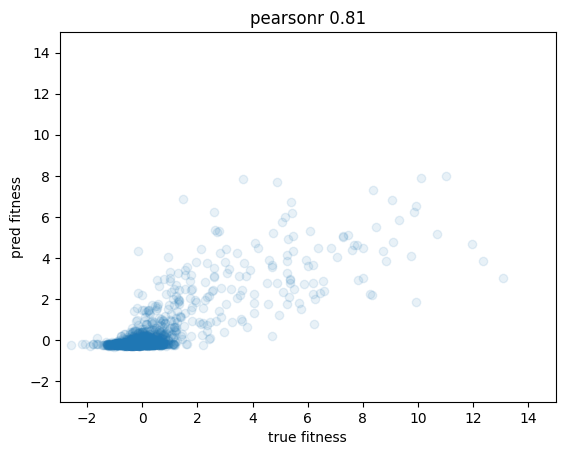

In [6]:
corr, _ = stats.pearsonr(y_true, mu)

plt.figure(dpi=100)
plt.scatter(x=y_true, y=mu,alpha=0.1)
plt.xlabel('true fitness')
plt.ylabel('pred fitness')
plt.title(f'pearsonr {corr:.2f}')
plt.xlim([-3,15])
plt.ylim([-3,15])

plt.show()

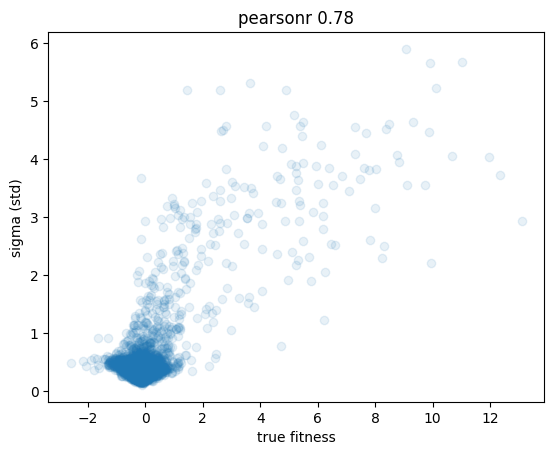

In [7]:
plt.figure(dpi=100)
corr, _ = stats.pearsonr(y_true, sigma)

plt.scatter(x=y_true, y=sigma, alpha=0.1)
plt.xlabel('true fitness')
plt.ylabel('sigma (std)')
plt.title(f'pearsonr {corr:.2f}')
plt.show()

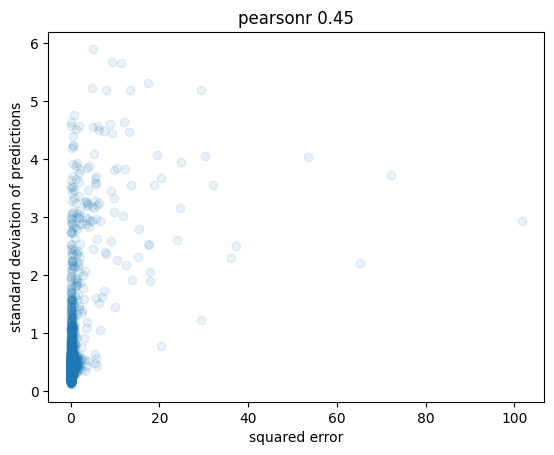

In [8]:
se = ((torch.tensor(y_true) - torch.tensor(mu))**2).tolist()
var = [x**2 for x in sigma]
corr, _ = stats.pearsonr(se, sigma)
plt.figure(dpi=100)
plt.scatter(x=se, y=sigma, alpha=0.1)
plt.xlabel('squared error')
plt.ylabel('standard deviation of predictions')
plt.title(f'pearsonr {corr:.2f}')
plt.show()

### checking to see if uncertainty correlates with distance from train set


In [165]:
train_data = data[~data['val']]
full_dataset = '/home/jgershon/git/cleo/data/four-site_clean_simplified_AA_data.csv'
full_data = pd.read_csv(full_dataset)

train_seqs = train_data['AAs'].tolist()
mean_dists = []
min_dists = []
for i,r in tqdm(full_data.iterrows()):
    val_seq = r['AAs']
    dists = []
    for train_seq in train_seqs:
        dist = sum([a!=b for a,b in zip(val_seq,train_seq)])
        dists.append(dist)

    min_dists.append(min(dists))
    mean_dists.append(torch.tensor(dists).float().mean().item())

full_data['min_dist'] = min_dists
full_data['mean_dist'] = mean_dists

159129it [07:44, 342.30it/s]


In [172]:
dataset = FragmentDataset(full_data,
                config.data.input_col,
                config.data.label_col,
                config.data.name_col,
                fragment_csv,
                config.data.use_fragment_representation,)

# run through the dataset
y_true = []
mu = []
sigma = []
pred_mean = []
pred_var = []

for x, y in tqdm(dataset):
    
    with torch.no_grad():
        
        output = model(x[None])
        mu.append(output["mu"].item())
        sigma.append(output["sigma"].item())
        pred_mean.append(output["mean"])
        pred_var.append(output["var"])
        y_true.append(y.item())

100%|██████████| 159129/159129 [09:03<00:00, 292.77it/s]


Text(0, 0.5, 'standard deviation of ensemble')

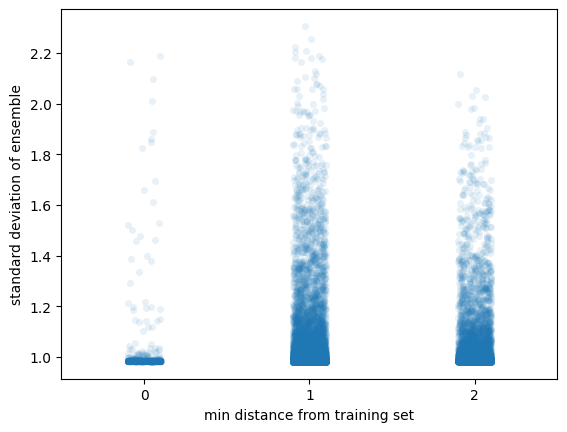

In [173]:
full_data['sigma'] = sigma

sns.stripplot(data=full_data, x='min_dist', y='sigma',alpha=0.1)
plt.xlabel('min distance from training set')
plt.ylabel('standard deviation of ensemble')